In [19]:
import numpy as np
import matplotlib.pyplot as plt

# _TODO_

# Import EEG data
Imports the `pre-processed.p` file generated by the [pre-processing notebook](preprocessing.ipynb).

Shapes:
- X: `(subject, trials, components, bands)`
- y: `(subject, trials)`

In [20]:
import pickle

with open('preprocessed.p', 'rb') as f:
    X, y = pickle.load(f)

n_subjects = X.shape[0]
for i, subj in enumerate(X):
    n_trials, n_components, n_bands = subj.shape
    print(f"Subject {i+1}: {n_trials} trials, {n_components} components, {n_bands} bands average power")

Subject 1: 434 trials, 6 components, 2 bands average power
Subject 2: 434 trials, 6 components, 2 bands average power
Subject 3: 434 trials, 6 components, 2 bands average power
Subject 4: 434 trials, 6 components, 2 bands average power
Subject 5: 434 trials, 6 components, 2 bands average power
Subject 6: 434 trials, 6 components, 2 bands average power


In [21]:
# # Dummy data (random matrix with same shape as EEG data)
# rng = np.random.default_rng(42)
# X = rng.standard_normal((6, 434, 6, 2)).astype(np.float32)
# y = rng.integers(0, 2, size=(6, 434), dtype=np.int8)

# n_subjects = X.shape[0]
# for i, subj in enumerate(X):
#     n_trials, n_components, n_bands = subj.shape
#     print(f"Subject {i+1}: {n_trials} trials, {n_components} components, {n_bands} bands' average power")

# SVM

In [22]:
# rows = one per trial and subject, columns = features (average power of two bands for each component)
X_svm = X.reshape(n_subjects * n_trials, n_components * n_bands)  
y_svm = y.reshape(n_subjects * n_trials)
# for each row, which subject it belongs to
subject_ids = np.repeat(np.arange(n_subjects), n_trials)  # shape = (n_subjects * n_trials,)

## Inter-subject (LeaveOneGroupOut)

In [23]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.svm import SVC

scores = [] # one accuracy score per subject left out
for train_idx, test_idx in LeaveOneGroupOut().split(X_svm, y_svm, groups=subject_ids):  # number of iterations = n_subjects
    X_train, X_test = X_svm[train_idx], X_svm[test_idx]
    y_train, y_test = y_svm[train_idx], y_svm[test_idx]

    print("\nSubject left out for testing:", subject_ids[test_idx[0]])
    print(f"Training on {X_train.shape[0]} samples, testing on {X_test.shape[0]} samples")
    print("Training set class distribution (0s and 1s):", np.bincount(y_train))
    print("Testing set class distribution (0s and 1s):", np.bincount(y_test))

    clf = SVC(kernel='linear')
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    print("Testing set predictions accuracy:", score)
    scores.append(score)

print("\nAverage cross-subject accuracy:", np.mean(scores))


Subject left out for testing: 0
Training on 2170 samples, testing on 434 samples
Training set class distribution (0s and 1s): [1127 1043]
Testing set class distribution (0s and 1s): [217 217]
Testing set predictions accuracy: 0.5

Subject left out for testing: 1
Training on 2170 samples, testing on 434 samples
Training set class distribution (0s and 1s): [1106 1064]
Testing set class distribution (0s and 1s): [238 196]
Testing set predictions accuracy: 0.4377880184331797

Subject left out for testing: 2
Training on 2170 samples, testing on 434 samples
Training set class distribution (0s and 1s): [1122 1048]
Testing set class distribution (0s and 1s): [222 212]
Testing set predictions accuracy: 0.5069124423963134

Subject left out for testing: 3
Training on 2170 samples, testing on 434 samples
Training set class distribution (0s and 1s): [1123 1047]
Testing set class distribution (0s and 1s): [221 213]
Testing set predictions accuracy: 0.5069124423963134

Subject left out for testing: 

## Intra-subject (K-fold CV)

In [24]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="linear"))
])

# Parameters that will be tested in the inner cross-validation:
# for each outer fold, the inner CV will select the best C among these values
param_grid = {
    "svm__C": [0.01, 0.1, 1, 10]    # Possible values for the SVM regularization parameter C
}

scores = []     # to store the accuracy scores from each outer fold
best_Cs = []    # to store the best C found in each outer fold
for train_idx, test_idx in outer_cv.split(X_svm, y_svm):
    X_train, X_test = X_svm[train_idx], X_svm[test_idx]
    y_train, y_test = y_svm[train_idx], y_svm[test_idx]

    grid = GridSearchCV(
        pipe,
        param_grid,
        cv=inner_cv,
        scoring="accuracy"
    )

    grid.fit(X_train, y_train)
    scores.append(grid.score(X_test, y_test))
    best_Cs.append(grid.best_params_["svm__C"])

    print(f"\nOuter fold {len(scores)}:")
    print(f"Training on {X_train.shape[0]} samples, testing on {X_test.shape[0]} samples")
    print("Training set class distribution (0s and 1s):", np.bincount(y_train))
    print("Testing set class distribution (0s and 1s):", np.bincount(y_test))
    print("Mean accuracy on test set:", scores[-1])
    print("Best C found in inner CV:", best_Cs[-1])

print("\nOverall average accuracy across outer folds:", np.mean(scores))



Outer fold 1:
Training on 2083 samples, testing on 521 samples
Training set class distribution (0s and 1s): [1075 1008]
Testing set class distribution (0s and 1s): [269 252]
Mean accuracy on test set: 0.5393474088291746
Best C found in inner CV: 10

Outer fold 2:
Training on 2083 samples, testing on 521 samples
Training set class distribution (0s and 1s): [1075 1008]
Testing set class distribution (0s and 1s): [269 252]
Mean accuracy on test set: 0.5412667946257198
Best C found in inner CV: 1

Outer fold 3:
Training on 2083 samples, testing on 521 samples
Training set class distribution (0s and 1s): [1075 1008]
Testing set class distribution (0s and 1s): [269 252]
Mean accuracy on test set: 0.5431861804222649
Best C found in inner CV: 10

Outer fold 4:
Training on 2083 samples, testing on 521 samples
Training set class distribution (0s and 1s): [1075 1008]
Testing set class distribution (0s and 1s): [269 252]
Mean accuracy on test set: 0.5374280230326296
Best C found in inner CV: 1

O

# DNN

In [158]:
import torch
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F

# rows = one per trial and subject, columns = features (average power of two bands for each component)
X_dnn = torch.tensor(X.reshape(n_subjects * n_trials, n_components * n_bands), dtype=torch.float32)
y_dnn = torch.tensor(y.reshape(n_subjects * n_trials), dtype=torch.long)

X_dnn_train, X_dnn_test, y_dnn_train, y_dnn_test = train_test_split(X_dnn, y_dnn, test_size=0.2, random_state=42, stratify=y_dnn)

In [ ]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super().__init__()
        self.hidden_layers = nn.ModuleList()
        current_size = input_size
        for hidden_size in hidden_sizes:
            self.hidden_layers.append(nn.Linear(current_size, hidden_size))
            current_size = hidden_size
        self.output_layer = nn.Linear(current_size, output_size)
    
    def forward(self, x):
        for layer in self.hidden_layers:
            x = F.elu(layer(x))
        return self.output_layer(x)  # raw logits for CrossEntropyLoss

# Hyperparameters and model
net = Net(input_size=X_dnn.shape[1], hidden_sizes=[64, 64, 64], output_size=2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

In [160]:
# Training loop
EPOCHS = 1000

train_losses = []   # training set loss per epoch
val_losses = []     # validation set loss per 10 epochs
train_accs = []     # training set accuracy per epoch
val_accs = []       # validation set accuracy per 10 epochs
for epoch in range(EPOCHS):
    net.train()
    optimizer.zero_grad()
    loss = criterion(net(X_dnn_train), y_dnn_train)
    acc = (net(X_dnn_train).argmax(1) == y_dnn_train).float().mean()
    train_losses.append(loss.item())
    train_accs.append(acc.item())
    loss.backward()
    optimizer.step()
    
    if epoch % (EPOCHS // 10) == 0:
        net.eval()
        with torch.no_grad():
            val_loss = criterion(net(X_dnn_test), y_dnn_test)
            val_acc = (net(X_dnn_test).argmax(1) == y_dnn_test).float().mean()
            val_losses.append(val_loss.item())
            val_accs.append(val_acc.item())
        print(f"Epoch {epoch}: loss={loss:.3f}, acc={acc:.3f}, val_loss={val_loss:.3f}, val_acc={val_acc:.3f}")

Epoch 0: loss=0.696, acc=0.516, val_loss=0.693, val_acc=0.509
Epoch 100: loss=0.681, acc=0.564, val_loss=0.689, val_acc=0.559
Epoch 200: loss=0.679, acc=0.567, val_loss=0.687, val_acc=0.543
Epoch 300: loss=0.677, acc=0.574, val_loss=0.685, val_acc=0.549
Epoch 400: loss=0.675, acc=0.575, val_loss=0.685, val_acc=0.543
Epoch 500: loss=0.673, acc=0.578, val_loss=0.685, val_acc=0.549
Epoch 600: loss=0.672, acc=0.581, val_loss=0.686, val_acc=0.549
Epoch 700: loss=0.669, acc=0.583, val_loss=0.686, val_acc=0.568
Epoch 800: loss=0.666, acc=0.587, val_loss=0.686, val_acc=0.568
Epoch 900: loss=0.662, acc=0.592, val_loss=0.688, val_acc=0.559


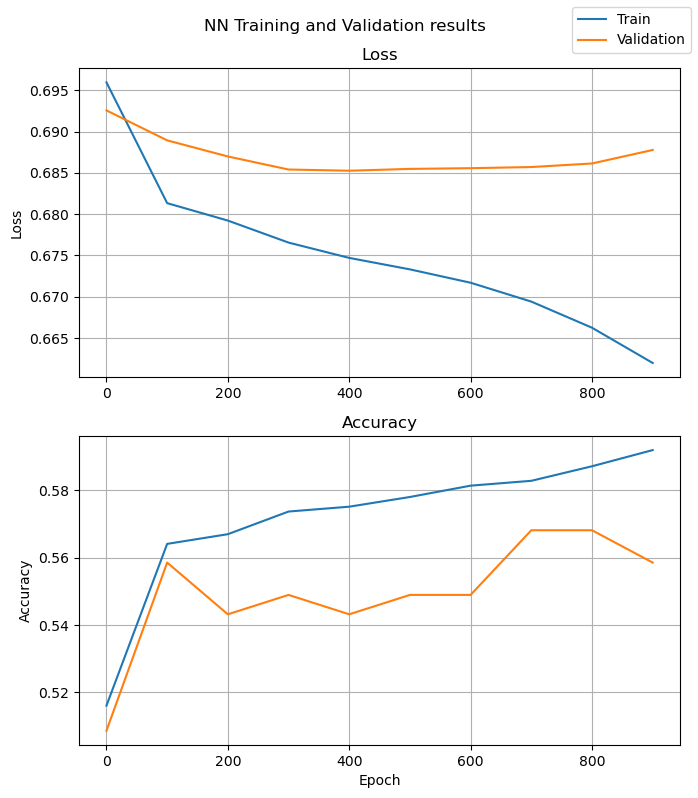

In [161]:
idxs = range(0, EPOCHS, EPOCHS // 10)
fig, axs = plt.subplots(2, 1, figsize=(7, 8))

axs[0].plot(idxs, [train_losses[idx] for idx in idxs], label="Train")
axs[0].plot(idxs, val_losses, label="Validation")
axs[0].set_ylabel("Loss")
axs[0].grid(True)
axs[0].set_title("Loss")

axs[1].plot(idxs, [train_accs[idx] for idx in idxs])
axs[1].plot(idxs, val_accs)
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].grid(True)
axs[1].set_title("Accuracy")

fig.legend()
fig.suptitle("NN Training and Validation results")
fig.tight_layout()
plt.show()

In [163]:
from sklearn.model_selection import StratifiedKFold

# Hyperparameters
EPOCHS = 1000
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
hidden_sizes = [64, 64, 64]
criterion = nn.CrossEntropyLoss()
optimizer_class = torch.optim.Adam

scores = []
for train_idx, test_idx in cv.split(X_dnn, y_dnn):
    X_train, X_test = X_dnn[train_idx], X_dnn[test_idx]
    y_train, y_test = y_dnn[train_idx], y_dnn[test_idx]
    
    net = Net(input_size=X_dnn.shape[1], hidden_sizes=hidden_sizes, output_size=2)
    optimizer = optimizer_class(net.parameters(), lr=1e-3)
    
    # Train net on X_train, y_train for EPOCHS
    for epoch in range(EPOCHS):
        net.train()
        optimizer.zero_grad()
        loss = criterion(net(X_train), y_train)
        loss.backward()
        optimizer.step()
        
        if epoch % (EPOCHS // 10) == 0:
            net.eval()
            with torch.no_grad():
                val_loss = criterion(net(X_test), y_test)
            print(f"Fold {len(scores)+1}, Epoch {epoch}: loss={loss:.3f}, val_loss={val_loss:.3f}")

    # Evaluate on X_test, y_test
    net.eval()
    with torch.no_grad():
        score = (net(X_test).argmax(1) == y_test).float().mean()
    scores.append(score.item())

print("Average CV accuracy:", np.mean(scores))

Fold 1, Epoch 0: loss=0.694, val_loss=0.693
Fold 1, Epoch 100: loss=0.681, val_loss=0.694
Fold 1, Epoch 200: loss=0.679, val_loss=0.695
Fold 1, Epoch 300: loss=0.677, val_loss=0.693
Fold 1, Epoch 400: loss=0.675, val_loss=0.691
Fold 1, Epoch 500: loss=0.674, val_loss=0.690
Fold 1, Epoch 600: loss=0.672, val_loss=0.691
Fold 1, Epoch 700: loss=0.670, val_loss=0.692
Fold 1, Epoch 800: loss=0.668, val_loss=0.695
Fold 1, Epoch 900: loss=0.667, val_loss=0.697
Fold 2, Epoch 0: loss=0.695, val_loss=0.694
Fold 2, Epoch 100: loss=0.681, val_loss=0.701
Fold 2, Epoch 200: loss=0.678, val_loss=0.704
Fold 2, Epoch 300: loss=0.676, val_loss=0.705
Fold 2, Epoch 400: loss=0.675, val_loss=0.703
Fold 2, Epoch 500: loss=0.673, val_loss=0.701
Fold 2, Epoch 600: loss=0.671, val_loss=0.701
Fold 2, Epoch 700: loss=0.669, val_loss=0.700
Fold 2, Epoch 800: loss=0.667, val_loss=0.700
Fold 2, Epoch 900: loss=0.666, val_loss=0.707
Fold 3, Epoch 0: loss=0.694, val_loss=0.692
Fold 3, Epoch 100: loss=0.684, val_loss=

# CNN

In [ ]:
import torch
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F

# X shape: (subjects, trials, channels, time)
X_cnn = torch.tensor(X.reshape(n_subjects * n_trials, n_components, n_samples), dtype=torch.float32)
y_cnn = torch.tensor(y.reshape(n_subjects * n_trials), dtype=torch.long)

X_cnn_train, X_cnn_test, y_cnn_train, y_cnn_test = train_test_split(
    X_cnn, y_cnn,
    test_size=0.2,
    random_state=42,
    stratify=y_cnn
)

In [ ]:
class CNN(nn.Module):
    def __init__(self, n_channels, n_classes):
        super().__init__()
        # () -> ()
        self.conv1 = nn.Conv1d(n_channels, 16, kernel_size=25, padding=12)
        # () -> ()
        self.conv2 = nn.Conv1d(16, 32, kernel_size=15, padding=7)
        # () -> ()
        self.pool = nn.AdaptiveAvgPool1d(1)
        # () -> ()
        self.fc = nn.Linear(32, n_classes)

    def forward(self, x):
        # x: (batch, channels, time_samples)
        x = F.elu(self.conv1(x))
        x = F.elu(self.conv2(x))
        x = self.pool(x)      # (batch, 32, 1)
        x = x.squeeze(-1)     # (batch, 32)
        return self.fc(x)     # raw logits

# Hyperparameters and model
net = CNN(n_channels=n_components, n_classes=2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

In [ ]:
# Training loop
EPOCHS = 1000

train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(EPOCHS):
    net.train()
    optimizer.zero_grad()

    logits = net(X_cnn_train)
    loss = criterion(logits, y_cnn_train)
    acc = (logits.argmax(1) == y_cnn_train).float().mean()

    train_losses.append(loss.item())
    train_accs.append(acc.item())

    loss.backward()
    optimizer.step()

    if epoch % (EPOCHS // 10) == 0:
        net.eval()
        with torch.no_grad():
            val_logits = net(X_cnn_test)
            val_loss = criterion(val_logits, y_cnn_test)
            val_acc = (val_logits.argmax(1) == y_cnn_test).float().mean()

        val_losses.append(val_loss.item())
        val_accs.append(val_acc.item())

        print(
            f"Epoch {epoch}: "
            f"loss={loss:.3f}, acc={acc:.3f}, "
            f"val_loss={val_loss:.3f}, val_acc={val_acc:.3f}"
        )


Epoch 0: loss=0.696, acc=0.516, val_loss=0.693, val_acc=0.509
Epoch 100: loss=0.681, acc=0.564, val_loss=0.689, val_acc=0.559
Epoch 200: loss=0.679, acc=0.567, val_loss=0.687, val_acc=0.543
Epoch 300: loss=0.677, acc=0.574, val_loss=0.685, val_acc=0.549
Epoch 400: loss=0.675, acc=0.575, val_loss=0.685, val_acc=0.543
Epoch 500: loss=0.673, acc=0.578, val_loss=0.685, val_acc=0.549
Epoch 600: loss=0.672, acc=0.581, val_loss=0.686, val_acc=0.549
Epoch 700: loss=0.669, acc=0.583, val_loss=0.686, val_acc=0.568
Epoch 800: loss=0.666, acc=0.587, val_loss=0.686, val_acc=0.568
Epoch 900: loss=0.662, acc=0.592, val_loss=0.688, val_acc=0.559


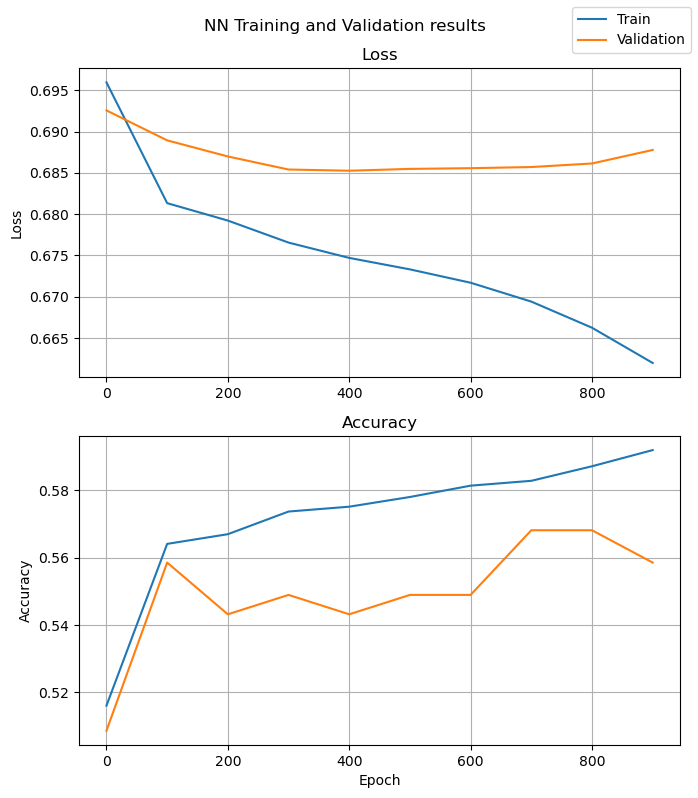

In [ ]:
idxs = range(0, EPOCHS, EPOCHS // 10)
fig, axs = plt.subplots(2, 1, figsize=(7, 8))

axs[0].plot(idxs, [train_losses[idx] for idx in idxs], label="Train")
axs[0].plot(idxs, val_losses, label="Validation")
axs[0].set_ylabel("Loss")
axs[0].grid(True)
axs[0].set_title("Loss")

axs[1].plot(idxs, [train_accs[idx] for idx in idxs])
axs[1].plot(idxs, val_accs)
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].grid(True)
axs[1].set_title("Accuracy")

fig.legend()
fig.suptitle("NN Training and Validation results")
fig.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

EPOCHS = 1000
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = []

for fold, (train_idx, test_idx) in enumerate(cv.split(X_cnn, y_cnn), 1):
    X_train, X_test = X_cnn[train_idx], X_cnn[test_idx]
    y_train, y_test = y_cnn[train_idx], y_cnn[test_idx]

    net = CNN(n_channels=n_components, n_classes=2)
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(EPOCHS):
        net.train()
        optimizer.zero_grad()
        loss = criterion(net(X_train), y_train)
        loss.backward()
        optimizer.step()

        if epoch % (EPOCHS // 10) == 0:
            net.eval()
            with torch.no_grad():
                val_loss = criterion(net(X_test), y_test)
            print(
                f"Fold {fold}, Epoch {epoch}: "
                f"loss={loss:.3f}, val_loss={val_loss:.3f}"
            )

    net.eval()
    with torch.no_grad():
        acc = (net(X_test).argmax(1) == y_test).float().mean()

    scores.append(acc.item())

print("Average CV accuracy:", np.mean(scores))

Fold 1, Epoch 0: loss=0.694, val_loss=0.693
Fold 1, Epoch 100: loss=0.681, val_loss=0.694
Fold 1, Epoch 200: loss=0.679, val_loss=0.695
Fold 1, Epoch 300: loss=0.677, val_loss=0.693
Fold 1, Epoch 400: loss=0.675, val_loss=0.691
Fold 1, Epoch 500: loss=0.674, val_loss=0.690
Fold 1, Epoch 600: loss=0.672, val_loss=0.691
Fold 1, Epoch 700: loss=0.670, val_loss=0.692
Fold 1, Epoch 800: loss=0.668, val_loss=0.695
Fold 1, Epoch 900: loss=0.667, val_loss=0.697
Fold 2, Epoch 0: loss=0.695, val_loss=0.694
Fold 2, Epoch 100: loss=0.681, val_loss=0.701
Fold 2, Epoch 200: loss=0.678, val_loss=0.704
Fold 2, Epoch 300: loss=0.676, val_loss=0.705
Fold 2, Epoch 400: loss=0.675, val_loss=0.703
Fold 2, Epoch 500: loss=0.673, val_loss=0.701
Fold 2, Epoch 600: loss=0.671, val_loss=0.701
Fold 2, Epoch 700: loss=0.669, val_loss=0.700
Fold 2, Epoch 800: loss=0.667, val_loss=0.700
Fold 2, Epoch 900: loss=0.666, val_loss=0.707
Fold 3, Epoch 0: loss=0.694, val_loss=0.692
Fold 3, Epoch 100: loss=0.684, val_loss=